## SMP Area Mapping Update
### Snohomish County Planning and Development Services (PDS)

    Author: Jesse Langdon, Principal GIS Analyst
    Created: 9/2/2022
    Last Modified: 9/2/2022

The **SMP Area Mapping Update** Jupyter Notebook updates Snohomish County's Shoreline Management Program area designations, to align with the most current version of delineated flood zones as outline in FEMA [Flood Hazard Areas (DFIRM) floodplain maps](https://snohomishcountywa.gov/893/DFIRM-Floodplain-Maps). The notebook utilizes the [Snohomish County ArcGIS Online](https://snoco-gis.maps.arcgis.com/) organizational environment to host and publish data, and ESRI's [ArcGIS API for Python](https://developers.arcgis.com/python/) to perform geoprocessing and associated data management tasks. The notebook is intended to be used as a tool to automate and document the update process.

References:
- [Shoreline Environment Designation](https://snohomish.county.codes/SCC/30.67.220)
- [Environment Designation Process 2.1](https://www.snohomishcountywa.gov/DocumentCenter/View/8142/Shoreline-Management-Program-2012?bidId=)

---

### Data Sources
This notebook assumes that source data has been compiled and imported into the **SMP_AreaUpdate_2022.aprx** project's associated file geodatabase - `SMP_AreaUpdate_2022.gdb`, and that enterprise geodatabases are available through the SnoCo corporate network.

These data sources are either feature classes or shapefile, and are described as follows:

|Dataset Name                           |Description                                                                                                              |
|---------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
|**floodzone**                          |Most recent FEMA flood hazard zone data, pulled from GIS_FEATURE enterprise geodatabase. Key attribute field is FLD_ZONE.|
|**smp**                                |Environmental designations developed as part of the Snohomish County Shoreline Management Program.                       |
|**cities**                             |Municipal boundaries of cities. Will be erased from the floodzone area polygon features.                                 |
|**hydro_waterbodies_200ftbuf**         |Waterbodies with 200ft shoreline setback buffers, used in the 2019 SMP update.                                           |
|**smp_2017_floodway_200ftbuf**         |Floodways with 200ft setback buffers, used in the 2019 SMP update.                                                       |
|**zoning_2022XXXX**                    |Feature class representing current Snohomish County zoning areas. Sourced from SCD_GIS_PROD                              |
|**DISTRICTS_national_forest**          |Feature class representing the current USFS national forest jurisdiction. Sourced from GIS_FEATURES                      |
|**TRIBAL__tribal_jurisdiction_parcels**|Tribal jurisdiction at the parcel level. Definition query applied - Snoco_LU_Jurisdiction = 'No'.                        |
|**TRIBAL_tideland_parcels**            |Tribal areas overlapping with tidelands. Removed from original SMP 2019 shoreland footprint.                             |

If these layers on not present in the APRX project map, please add them from the `SMP_AreaUpdate_2022.gdb` file geodatabase or from SnoCo enterprise geodatabases.

---

## Step 1: Generate a layer which indicates how the SMP footprint should be updated
The first step in the updating the Snohomish County shoreline environment designation map is to update the shoreline jurisdiction footprint to reflect changes in FEMA flood hazard areas and recent municipal annexations. This process includes the following steps:
1. Filter the current flood hazard polygon feature class to only include polygon features WHERE FLD_ZONE NOT IN ('X', 'OPEN WATER'). This removes polygon features with X flood hazard zone types (and open water), with hazard zones A, AE, AH, AO, VE remaining in the dataset for subsequent analysis.
2. Remove current municipal footprints and tribal jurisdiction.
3. Union the updated flood hazard layer with the most recent SMP environmental designation footprint layer.
4. Categorize the resulting polygon features with values indicating how the polygon features will be treated in the update process. These values include:
    * No change to SMP area
    * Subtract SMP area
    * Expand SMP area
    * Not included in analysis

#### Pre-analysis data preparations

* **Waterbodies with 200-ft setback buffers**: Open water features - which were originally mapped in the 2019 SMP - should not be included in the environmental designation footprint update process. The hydro_waterbodies_200ftbuf layer is used to refine the floodzone layer, by erasing areas from that flood zone layer's footprint where overlapping occurs. The hydro_waterbodies_200ftbuf feature class, which was pulled from the PDS-GIS Shoreline Management Program archive directories (\\snoco\gis\plng\carto\Projects\ShorelineManagementProgram), had missing waterbody polygon features manually added. These waterbodies, and their 200-ft setback buffer polygons, were manually digitized into the hydro_Waterbodies_200ftbuf feature class by tracing features from the smp_2019 feature class, with the waterbody names then populated in the hydro_waterbodies_200ftbuf.**NAME** attribute field. In addition, the hydro_Waterbodies_200ftbuf.**Notes** attribute field was populated with 'Added for SMP 2022 area change' for each digitized water body feature.


* **Floodways with 200-ft setback buffers**: Similarly to the waterbodies layer mentioned above, floodways within the 200-ft setback buffers should also be removed from the flood hazard zone footprint, and only floodplains expanding outside of these buffer areas should be considered a "true expansion" of the footprint. The smp_2017_floodway_200ftbuf feature class required manual edits to include missing buffered floodway features. New buffer features were added by digitization (tracing the missing floodway buffer features in SMP feature class). Again, for each new feature, the string value 'Added for SMP 2022 area change' was added to a newly-added "Notes" attribute field.

In [1]:
# Run this before executing any other cells in this Jupyter Notebook

# import modules
import os, datetime, arcpy
arcpy.env.overwriteOutput = True

# global variables
smp_gdb = r"\\snoco\gis\plng\carto\Projects\ShorelineManagementProgram\2022\SMP_AreaUpdate_2022\SMP_AreaUpdate_2022.gdb"
filepath = r'\\snoco\gis\plng'
pds_gdb_connect = 'GDB_connections\WIN_USER@SCD_GIS_PUBLISH.sde'

In [ ]:
# convert flood hazard zone to 100-year flood polygon features only, resulting in-memory feature class
arcpy.conversion.FeatureClassToFeatureClass(
                                            in_features = 'floodzone',
                                            out_path = 'memory',
                                            out_name = '_1floodzone_100yrfld',
                                            where_clause = "FLD_ZONE <> 'X'")
flood_select_count = arcpy.management.GetCount(r'memory\_1floodzone_100yrfld')
print("Count of selected flood hazard 100-year polygon features: ", flood_select_count)

# dissolve 100-year flood hazard polygon features into a single polygon feature.
arcpy.management.Dissolve(in_features ='_1floodzone_100yrfld',
                          out_feature_class =r'memory\_2floodzone_dslv',
                          multi_part = 'MULTI_PART')
dissolve_count = arcpy.management.GetCount('_2floodzone_dslv')
if int(dissolve_count[0]) == 1:
    print("100-year floodplain features successfully dissolved...")
    
# dissolve all SMP 2019 features into a single polygon feature.
arcpy.management.Dissolve(in_features = 'smp',
                          out_feature_class = r'memory\_3smp_dslv',
                          multi_part = 'MULTI_PART')
dissolve_count = arcpy.management.GetCount(r'memory\_3smp_dslv')
if int(dissolve_count[0]) == 1:
    print("SMP features successfully dissolved...")

# create layers for datasets that represent non-SMP jurisdictions.
filepath = r'\\snoco\gis\plng'
gdb_connect = 'GDB_connections\WIN_USER@GIS_FEATURES_PAG-GIS.sde'
arcpy.management.MakeFeatureLayer(in_features = os.path.join(filepath, gdb_connect, 'GIS_FEATURES.GDBA.DISTRICTS__national_forest'),
                                  out_layer = 'DISTRICTS_national_forest') 
arcpy.management.MakeFeatureLayer(in_features = os.path.join(filepath, gdb_connect, 'GIS_FEATURES.GDBA.TRIBAL__tribal_jurisdiction_parcels'),
                                  out_layer = 'TRIBAL_jurisdiction_parcels')
arcpy.management.MakeFeatureLayer(in_features = os.path.join(filepath, r'carto\Projects\ShorelineManagementProgram\2016\GEOPROCESSING\20170417\2019_SMP_areas_tobe_removed_from_Tribal_tideland_areas_final.shp'),
                                  out_layer = 'Tribal_tideland_parcels')

# erase non-SMP jurisdictional areas from the flood hazard areas
arcpy.analysis.Erase(in_features = r'memory\_1floodzone_100yrfld',
                     erase_features = 'cities',
                     out_feature_class = r'memory\_4floodzone_erased_cities')
print("City boundaries removed from flood hazard zone areas...")
arcpy.analysis.Erase(in_features = r'memory\_4floodzone_erased_cities',
                     erase_features = 'TRIBAL_jurisdiction_parcels',
                     out_feature_class = r'memory\_4floodzone_erased_tribaljuris')
print("Tribal jurisdiction removed from flood hazard zone areas...")
arcpy.analysis.Erase(in_features = r'memory\_4floodzone_erased_tribaljuris',
                     erase_features = 'Tribal_tideland_parcels',
                     out_feature_class = r'memory\_4floodzone_erased_tribaltideland')
print("Tribal tidelands removed from flood hazard zone areas...")

# create layer of recent municipal annexations to determine SMP areas that should be removed
muni_annex_qry = "EFFECTDATE > '2020-01-01 00:00:00'" # Should be determined based on when latest SMP was published
arcpy.management.MakeFeatureLayer(in_features = os.path.join(filepath, gdb_connect, 'GIS_FEATURES.GDBA.DISTRICTS__muni_annex'),
                                  out_layer = 'DISTRICTS__muni_annex', 
                                  where_clause = muni_annex_qry)

# union flood hazard zones, the dissolved SMP 2019 footprint, and floodway buffers that will restrict the footprint change analysis.
arcpy.analysis.Union(in_features = [r'memory\_4floodzone_erased_tribaltideland',
                                    r'memory\_3smp_dslv',
                                    'hydro_waterbodies_200ftbuf',
                                    'smp_2017_floodway_200ftbuf'],
                     out_feature_class = r'memory\_5union_flood_smp',
                     join_attributes = 'ONLY_FID')
print("All input features unioned...")

# Add new text column for category type
arcpy.management.AddField(in_table = r'memory\_5union_flood_smp',
                          field_name = 'update_category',
                          field_type = 'TEXT',
                          field_length = '25')
print("New 'update_category' column added to union layer...")

# Populate the 'update_category' attribute field with catagory types based on joined FID column values. This results in a 
# polygon layer that represents the SMP 2019 change analysis footprint.
union_field_names = ['FID__4floodzone_erased_tribaltideland', 
                     'FID__3smp_dslv', 
                     'FID_hydro_waterbodies_200ftbuf',
                     'FID_smp_2017_floodway_200ftbuf',
                     'update_category']
with arcpy.da.UpdateCursor(in_table = r'memory\5union_flood_smp',
                           field_names = union_field_names) as cursor:
    # For each row, evaluate if the FID column from the unioned feature classes is equal to -1. A value of -1 indicates that
    # that features from the unioned source are not present. If a FID value is greater than -1, the source feature from the 
    # unioned feature class was present. The update_category column is updated based on these logical combinations.
    for row in cursor:
        if (row[0] == -1 and row[1] > -1 and row[2] == -1 and row[3] == -1):
            # floodzone = FALSE, SMP = TRUE, bufferered waterbody = FALSE, buffered floodway = FALSE
            row[4] = 'Subtract SMP area'
        elif (row[0] > -1 and row[1] == -1 and row[2] == -1 and row[3] == -1):
            # floodzone = TRUE, SMP = FALSE, bufferered waterbody = FALSE, buffered floodway = FALSE
            row[4] = 'Expand SMP area'
        elif (row[0] > -1 and row[1] > -1 and row[2] == -1 and row[3] == -1):
            # floodzone = TRUE, SMP = TRUE, bufferered waterbody = FALSE, buffered floodway = FALSE
            row[4] = 'No change to SMP area'
        elif (row[0] > -1 and row[1] > -1 and row[2] == -1 and row[3] > -1):
            # floodzone = TRUE, SMP = TRUE, bufferered waterbody = FALSE, buffered floodway = TRUE
            row[4] = 'No change to SMP area'
        elif (row[0] > -1 and row[1] > -1 and row[2] > -1 and row[3] == -1):
            # floodzone = TRUE, SMP = TRUE, bufferered waterbody = TRUE, buffered floodway = FALSE
            row[4] = 'No change to SMP area'
        elif (row[0] == -1 and row[1] > -1 and row[2] > -1 and row[3] > -1):
            # floodzone = FALSE, SMP = TRUE, bufferered waterbody = TRUE, buffered floodway = TRUE
            row[4] = 'No change to SMP area'
        elif (row[0] == -1 and row[1] > -1 and row[2] == -1 and row[3] > -1):
            # floodzone = FALSE, SMP = TRUE, bufferered waterbody = FALSE, buffered floodway = TRUE
            row[4] = 'No change to SMP area'
        elif (row[0] == -1 and row[1] > -1 and row[2] > -1 and row[3] == -1):
            # floodzone = FALSE, SMP = TRUE, bufferered waterbody = TRUE, buffered floodway = FALSE
            row[4] = 'No change to SMP area'
        elif (row[0] > -1 and row[1] > -1 and row[2] > -1 and row[3] > -1):
            # floodzone = TRUE, SMP = TRUE, bufferered waterbody = TRUE, buffered floodway = TRUE
            row[4] = 'No change to SMP area'
        elif (row[0] == -1 and row[1] == -1 and row[2] > -1 and row[3] == -1):
            # floodzone = FALSE, SMP = FALSE, bufferered waterbody = TRUE, buffered floodway = FALSE
            row[4] = 'Not included in analysis'
        elif (row[0] == -1 and row[1] == -1 and row[2] == -1 and row[3] > -1):
            # floodzone = FALSE, SMP = FALSE, bufferered waterbody = FALSE, buffered floodway = TRUE
            row[4] = 'Not included in analysis'
        elif (row[0] == -1 and row[1] == -1 and row[2] > -1 and row[3] > -1):
            # floodzone = FALSE, SMP = FALSE, bufferered waterbody = TRUE, buffered floodway = TRUE
            row[4] = 'Not included in analysis'
        elif (row[0] > -1 and row[1] == -1 and row[2] > -1 and row[3] == -1):
            # floodzone = TRUE, SMP = FALSE, bufferered waterbody = TRUE, buffered floodway = FALSE
            row[4] = 'Expand SMP area'
        elif (row[0] > -1 and row[1] == -1 and row[2] == -1 and row[3] > -1):
            # floodzone = TRUE, SMP = FALSE, bufferered waterbody = FALSE, buffered floodway = TRUE
            row[4] = 'Expand SMP area'
        cursor.updateRow(row)

print('Footprint categories updated...')

# Change annexed areas of the update footprint to "Subtract SMP area" (doesn't work in previous cell for some reason)
arcpy.analysis.Union(in_features = [r'memory\_5union_flood_smp', 'DISTRICTS__muni_annex'],
                     out_feature_class = r'memory\_6union_annex',
                     join_attributes = 'ALL')

union_field_names = ['FID_DISTRICTS__muni_annex',
                     'update_category']

with arcpy.da.UpdateCursor(in_table = r'memory\_6union_annex',
                           field_names = union_field_names) as cursor:
    # For each row, evaluate if the FID column from the unioned feature classes is equal to -1. A value of -1 indicates that
    # that features from the unioned source are not present. If a FID value is greater than -1, the source feature from the 
    # unioned feature class was present. The update_category column is updated based on these logical combinations.
    for row in cursor:
        if (row[0] > -1):
            # municipal annexation = TRUE
            row[1] = 'Subtract SMP area'
        cursor.updateRow(row)
print("Annexed areas changed to 'Subtract SMP area'")

# create field mapping for the exported footprint feature class
footprint_layer = 'update_footprint'
in_field = 'update_category'
fms = arcpy.FieldMappings()
fm = arcpy.FieldMap()
fm.addInputField(r'memory\_6union_annex', in_field)
fms.addFieldMap(fm)

# export the update union result to the project's file geodatabase as a feature class
arcpy.conversion.FeatureClassToFeatureClass(in_features = r'memory\_6union_annex',
                                            out_path = smp_gdb,
                                            out_name = footprint_layer,
                                            field_mapping = fms)
print('{0} imported to {1}...'.format(footprint_layer, arcpy.env.workspace))

# symbolize the layer in the maps TOC using the unique values in the update_category attribute field
p = arcpy.mp.ArcGISProject('CURRENT')
m = p.listMaps('Map')[0]
l = m.listLayers('update_footprint')[0]
sym = l.symbology

sym.updateRenderer('UniqueValueRenderer')
sym.renderer.field = ['update_category']
for group in sym.renderer.groups:
    for item in group.items:
        if item.label == 'Expand SMP area':
            item.symbol.color = {'RGB': [0, 112, 255, 80]}
        elif item.label == 'No change to SMP area':
            item.symbol.color = {'RGB': [56, 168, 0, 80]}
        elif item.label == 'Subtract SMP area':
            item.symbol.color = {'RGB': [255, 80, 0, 80]}
        elif item.label == 'Not included in analysis':
            item.symbol.color = {'RGB': [96, 96, 96, 80]}
l.symbology = sym

# remove all temporary layers from the map's TOC
import re #import regex module
layers = m.listLayers()
for lyr in layers:
    if re.match(r'_', lyr.name):
        print('Removing {} layer from map...'.format(lyr.name))
        m.removeLayer(lyr)

## Step 2: Refine the update footprint based on Shorelines of the State (MANUAL EDIT)

Now that we have determined the footprint with categories outlining how to update the shoreline environmental designations for the most recent SMP, a follow-up step is required to refine the footprint further. 

Shorelines of the State are determined by the county for each version of the SMP. The Shorelines of the State are included as an attribute value in the County's hydrography datasets, waterbodies and watercourses, and features can be filtered from these datasets using the following definition query:
`WTRTY_CD IN ('S1', 'S')`
 
FEMA updates the flood hazard area maps without considering Shorelines of the State, which in Washington are determined by the Department of Ecology and WA Dept. of Fish & Wildlife. So polygon features in the update_footprint layer labeled as "Expand SMP Area" that do NOT coincide with Shorelines of the State should be removed from the update footprint. Unfortunately, this is difficult to automate, and requires spatial editing of the footprint on a case-by-case basis.

Example of splitting the update_footprint layer using a buffer around a Shorelines of the Statewide Signficance water course:
<div>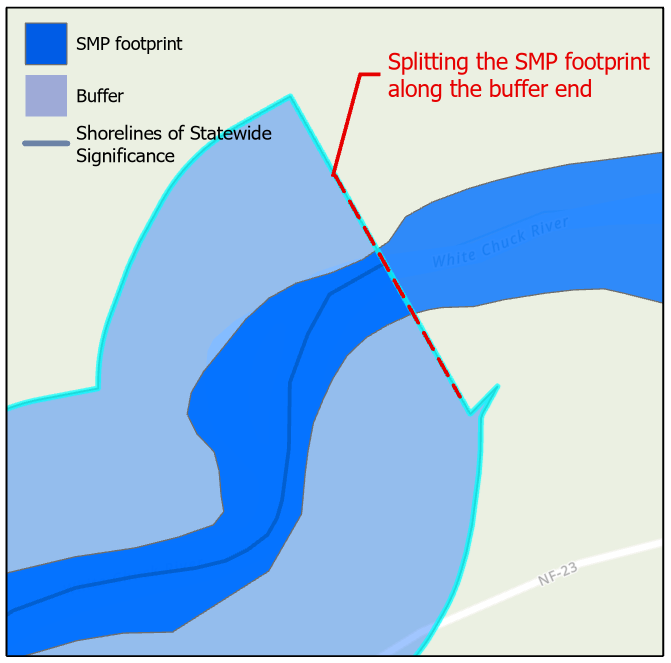</div>

In [2]:
'''Select Shorelines of the State from the GIS_FEATURES.GDBA.HYDROGRAPHY__watercourse_snoco feature class, and generate
a 500-foot buffer  with flat ends to use as a guide to split polygon features with the 'Expand SMP area' category.''' 
arcpy.analysis.Buffer(in_features = "Shorelines of the State\Watercourses" ,
                      out_feature_class = r"memory\Watercourses_buf500ft",
                      buffer_distance_or_field = "500 foot",
                      line_side = "FULL",
                      line_end_type = "FLAT",
                      dissolve_option = "ALL")
print("500-foot buffer generated for Shorelines of the State...")

500-foot buffer generated for Shorelines of the State...


A new text attribute field should be added to the **update_footprint** layer called "SOS" (i.e. Shoreline of the State"), which will be populated with "True" by default.  The "Expanded SMP area" polygons should be split along the ends of the Shorelines of the State buffer, and the resulting split polyon features should be tagged as SOS = "False" if the polygon feature does *not* overlap with buffered area.

In [ ]:
# Add new text column 'update_footprint' layer to indicate if the polygon is a Shoreline of the State
arcpy.management.AddField(in_table = 'update_footprint',
                          field_name = 'SOS',
                          field_type = 'TEXT',
                          field_length = '5')
print("New 'update_category' column added to union layer...")

# Populate the new column with "True" as the default value
with arcpy.da.UpdateCursor(in_table = 'update_footprint',
                           field_names = 'SOS') as cursor:
    for row in cursor:
        row[0] = 'True'
        cursor.updateRow(row)

# Before manual edits, the update_footprint layer must have the geometry repaired
arcpy.management.RepairGeometry(in_features = 'update_footprint',
                                delete_null = 'KEEP_NULL')

print('New SOS column updated with default value.')
print('update_footprint layer is ready for manual editing!')

## Step 3: Cross-walk shoreline environment designations from current zoning
All polygon features in the update footprint layer that are categorized as **Expand SMP area** must have new shoreline environment designations assigned. These designations are derived from current zoning, based on parameters outlined in section 30.67.220 of the County Shoreline Managment Program code, specifically subsections *c, d*, and *e*. 

This step includes the following processes:
1. Copy the current zoning feature class from the PDS PUBLISH enterprise geodatabase to the project geodatabase, using field mapping to only include zoning codes.
2. Union the copied zoning polygon layer with UGA polygons from the GIS_FEATURES geodatabase, and the edited update footprint layer.
3. Add a new attribute field to the unioned polygon layer for storing SMP designation values.
4. Iterate through the unioned polygon features to populate SMP designation values based on joined FID logic and the table outlined below:

#### Zoning/UGA status to SMP designation cross-walk table
|Zoning query                   |UGA      |Shoreline Environment Designation           |
|-------------------------------|---------|--------------------------------------------|
|N/A                            |Inside   |**Urban Shoreline Environment**             |
|???                            |Inside   |**Urban Conservancy Shoreline Environment** |
|ZONE_CD NOT IN (151, 101, 102) |Outside  |**Rural Conservancy Shoreline Environment** |
|ZONE_CD IN (151, 101, 102)     |Outside  |**Resource Shoreline Environment**          |
|???                            |Outside  |**Natural Shoreline Environment**           |


In [ ]:
# make zoning a layer in the current project's table of contents
zoning_fc = os.path.join(filepath, pds_gdb_connect, 'SCD_GIS_PUBLISH.SCD_GDBA.ZONING__CURRENT__zoning_poly')

# create field mapping for the current zoning layer
fms = arcpy.FieldMappings()
fm_zone = arcpy.FieldMap()
fm_zone.addInputField(zoning_fc, 'ZONE_CD')
fms.addFieldMap(fm_zone)

# export the zoning layer to the project's file geodatabase as a feature class
arcpy.conversion.FeatureClassToFeatureClass(in_features = zoning_fc,
                                            out_path = smp_gdb,
                                            out_name = 'zoning',
                                            field_mapping = fms)
print('zoning imported to {0}...'.format(arcpy.env.workspace))

# create new update footprint layer which only includes features with the 'Expand SMP area' category
arcpy.management.MakeFeatureLayer(in_features = 'update_footprint_SoSremoved',
                                  out_layer = 'update_footprint_expand',
                                  where_clause = "update_category = 'Expand SMP area'")
print('Made new layer representing areas of footprint expansion...')

# union the zoning layer with the urban growth area (UGA) feature class and the 'expand' footprint layer
update_footprint_expand = 'update_footprint_expand'
zoning_smp_fc = os.path.join(smp_gdb, 'zoning')
uga_fc = os.path.join(filepath, 
                      pds_gdb_connect, 
                      'SCD_GIS_PUBLISH.SCD_GDBA.PLANNING',
                      'SCD_GIS_PUBLISH.SCD_GDBA.PLANNING__FLU__urbangrowth')
union_list = [update_footprint_expand, zoning_smp_fc, uga_fc]
arcpy.analysis.Union(in_features = union_list,
                     out_feature_class = os.path.join(smp_gdb, 'union_zoning_uga'),
                     join_attributes = 'ALL')
print('Unioned the footprint expansion layer with zoning and SMP designation layers...')

# Add new text column 'LABEL' to the union_zoning_uga layer to store the cross-walked SMP designation
arcpy.management.AddField(in_table = 'union_zoning_uga',
                          field_name = 'LABEL',
                          field_type = 'TEXT',
                          field_length = '100')
print("New LABEL attribute field added to union_zoning_uga layer...")

# Populate the 'LABEL' attribute field with SMP designations based on joined FID column values.
union_field_names = ['FID_update_footprint_SoSremoved', 
                     'FID_PLANNING__FLU__urbangrowth', 
                     'FID_zoning',
                     'ZONE_CD',
                     'LABEL']
with arcpy.da.UpdateCursor(in_table = r'union_zoning_uga',
                           field_names = union_field_names) as cursor:
    # For each row, evaluate if the FID column from the unioned feature classes is equal to -1. A value of -1 indicates that
    # that features from the unioned source are not present. If a FID value is greater than -1, the source feature from the 
    # unioned feature class was present. The update_category column is updated based on these logical combinations.
    for row in cursor:
        if (row[0] > -1 and row[1] > -1 and row[2] > -1):
            row[4] = 'Urban Shoreline Environment'
        if (row[0] > -1 and row[1] == -1 and row[2] > -1 and row[3] not in (151, 101, 102)):
            row[4] = 'Rural Conservancy Shoreline Environment'
        if (row[0] > -1 and row[1] == -1 and row[2] > -1 and row[3] in (151, 101, 102)):
            row[4] = 'Resource Shoreline Environment'
        cursor.updateRow(row)
print("LABEL attribute field in union_zoning_uga layer updated...")

# symbolize the layer in the project's TOC using the unique designation values in the LABEL attribute field
p = arcpy.mp.ArcGISProject('CURRENT')
m = p.listMaps('Map')[0]
l = m.listLayers('union_zoning_uga')[0]
sym = l.symbology
sym.updateRenderer('UniqueValueRenderer')
sym.renderer.fields = ['LABEL']
for group in sym.renderer.groups:
    for item in group.items:
        if item.label == 'Resource Shoreline Environment':
            item.symbol.color = {'RGB': [219, 100, 82, 25]}
        elif item.label == 'Rural Conservancy Shoreline Environment':
            item.symbol.color = {'RGB': [205, 205, 100, 25]}
        elif item.label == 'Urban Shoreline Environment':
            item.symbol.color = {'RGB': [132, 0, 168, 25]}
        else:
            item.symbol.color = {'RGB': [130, 130, 130, 95]}
l.symbology = sym
print("update_zoning_uga layer symbology updated...")

# Add new text column 'ReviseDate' to the union_zoning_uga feature class to store date value indicating the 
# LABEL attribute is changed
arcpy.management.AddField(in_table = 'union_zoning_uga',
                          field_name = 'ReviseDate',
                          field_type = 'DATE')
print("New 'LABEL' column added to union_zoning_uga layer...")

## Step 4: Categorization of Natural and Urban Conservancy designations (MANUAL EDIT)
The next step requires an additional manual effort. In this step, the analyst must find polygons representing areas of footprint expansion that should actually be categorized as 'Natural Shoreline Environment' and 'Urban Conservancy Shoreline Environment' designations. The previous automated processes likely resulted in polygon features in the update_footprint layer that are categorized as either 'Urban' or 'Rural Conservancy'. If these 'Urban' or 'Rural Conservancy' areas share a boundary with existing areas that are designated as 'Urban Conservancy' or 'Natural', *and* the underlying zoning remains the same, then those area designations should be changed as follows:

* Resource Shoreline Environment -> Natural Shoreline Environment
* Urban Shoreline Environment -> Urban Conservancy Shoreline Environment

*See section 30.67.220 (Shoreline environment designation maps) for reference*: [Shoreline Environment Designation](https://snohomish.county.codes/SCC/30.67.220)

In the figure below, the dark purple polygons were categorized with a 'Urban Shoreline Environment' designation by previous processing steps, however they actually represent an expansion of the existing 'Urban Conservancy Shoreline Environment' (since the underlying zoning is unchanged between both areas):
<div>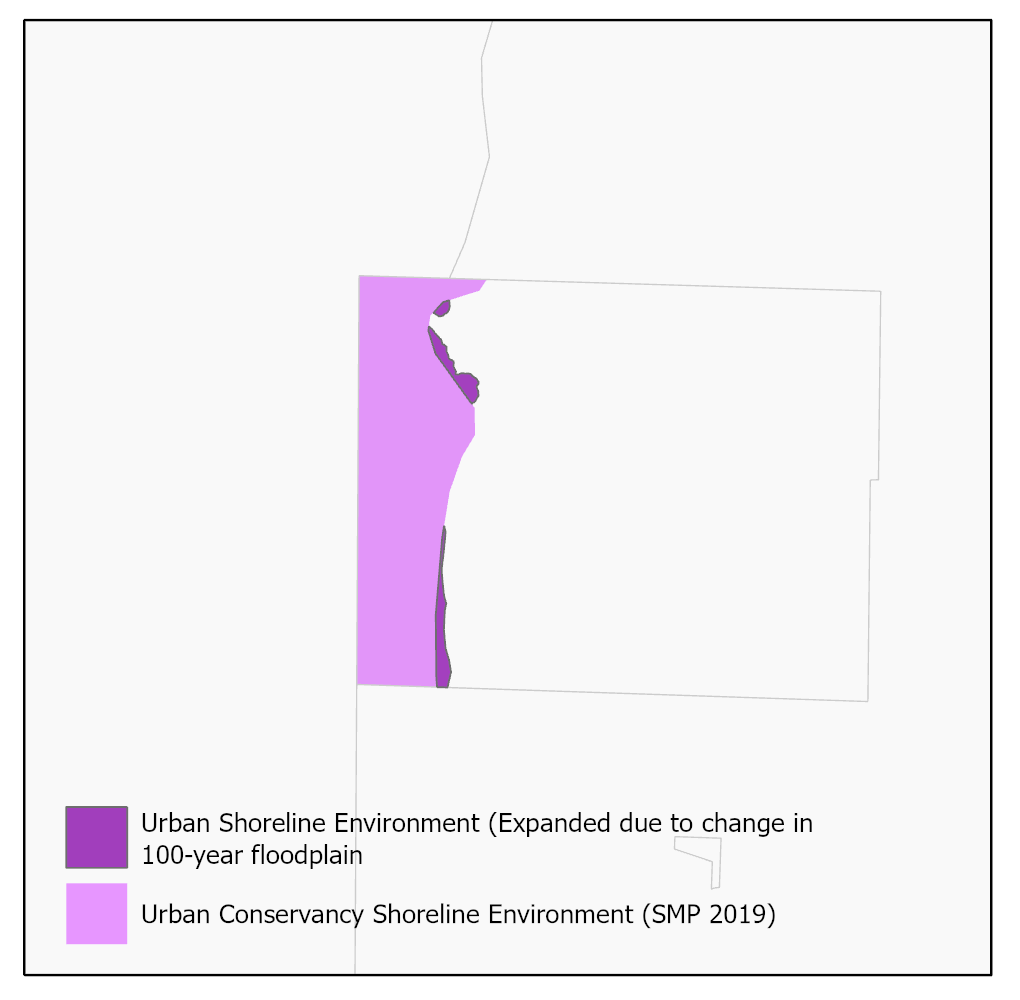</div>

Similarly in this figure, the orange polygon designated as 'Resource Shoreline Environment' should be changed to 'Natural Shoreline Environment':
<div>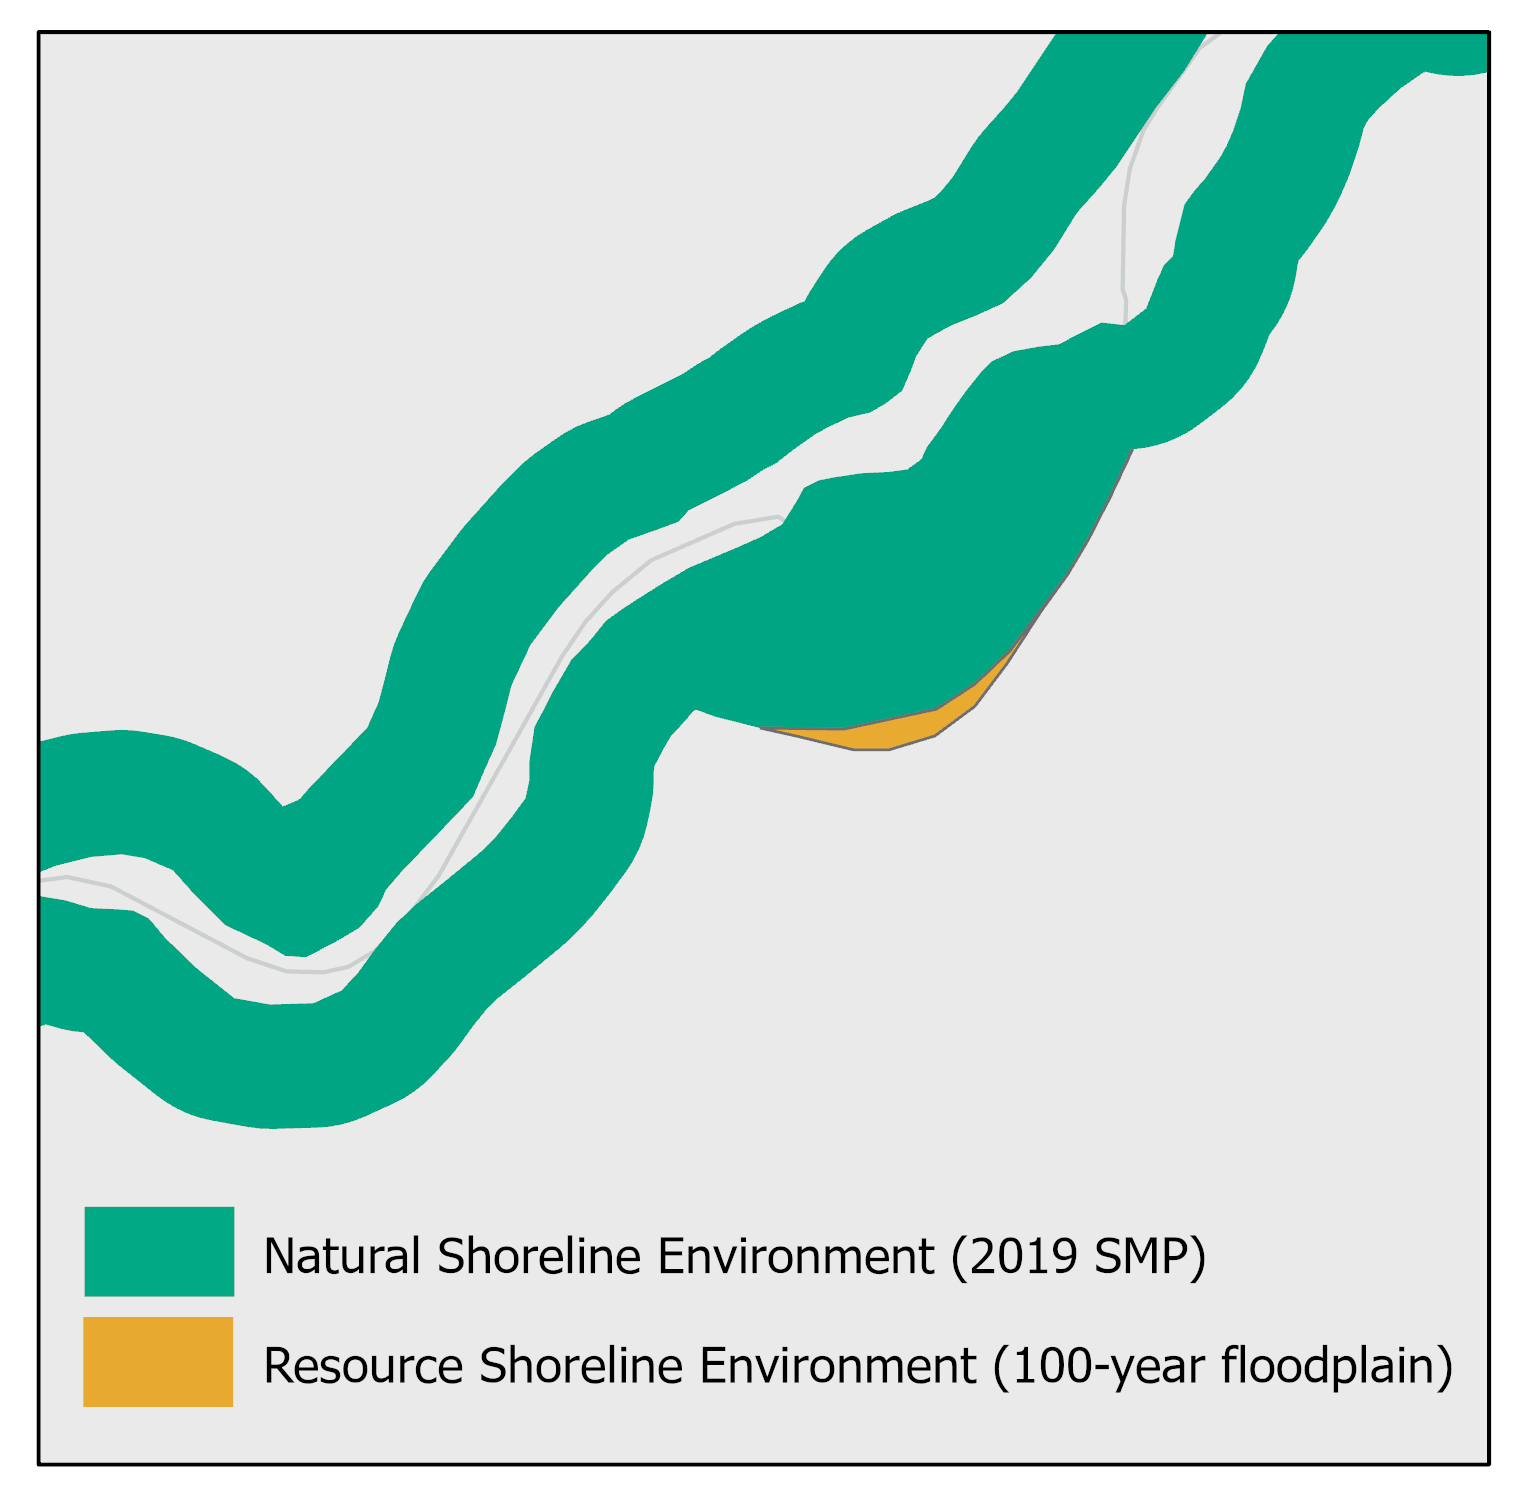</div>

## Step 5: Finalize the update footprint

Upon completion of the Step 4, the final version of the update footprint layer must now be assembled. The required processing steps include:

1. Erase polygon features categorized as 'Subtract SMP area' from the most recent SMP designation feature class.
2. Append polygon features categorized as 'Expand SMP area' to the SMP designation feature class.
3. Dissolve all features by shoreline environmental designation, minus the 'Not included in analysis' features.
3. Export dissolved layer to new feature class in the project geodatabase.

Once the updated SMP layer has exported to the project geodatabase, the final dataset represents SMP environmental designations that have been updated with the FEMA 2019 100-year floodplain and recent municipal annexations. The feature class will now be available for publishing on the Snohomish County ArcGIS Online (AGOL) platform.

In [37]:
# import modules
import os, datetime, arcpy
arcpy.env.overwriteOutput = True

# global variables
smp_gdb = r"\\snoco\gis\plng\carto\Projects\ShorelineManagementProgram\2022\SMP_AreaUpdate_2022\SMP_AreaUpdate_2022.gdb"

# Create new layer representing the areas to subtract from the footprint, based on the updated 100-year floodplain mapping
arcpy.management.MakeFeatureLayer(in_features = 'update_footprint_SoSremoved',
                                  out_layer = 'update_footprint_subtract',
                                  where_clause = "update_category = 'Subtract SMP area'")
print("Made new layer with only 'Subtract SMP area' features...")

# Erase the 'subtract' features from the SMP environmental designation layer
arcpy.analysis.Erase(in_features = 'smp',
                     erase_features = 'update_footprint_subtract',
                     out_feature_class = 'memory\smp_subtract')
print("Erased 'subtract' features from SMP layer...")

# Clear selections from union_zoning_uga layer
arcpy.management.SelectLayerByAttribute(in_layer_or_view = 'union_zoning_uga',
                                        selection_type = "CLEAR_SELECTION" )

# Append the 'expand' features to the resulting layer. Using this method because I hate using fieldmapping
append_fields = ['LABEL', 'SHAPE@']
insert_cur = arcpy.da.InsertCursor(in_table = 'smp_subtract', field_names = append_fields)
with arcpy.da.SearchCursor(in_table = 'union_zoning_uga',
                           field_names = append_fields,
                           where_clause = 'LABEL IS NOT NULL') as search_cursor:
    for row in search_cursor:
        insert_cur.insertRow(row)
del insert_cur
print('The union_zoning_uga appended to the subtract SMP layer...')

# Dissolve features in the resulting feature class and save in the project file geodatabase
current_date_obj = datetime.date.today()
current_date_str = current_date_obj.strftime('%Y%m%d')
arcpy.management.Dissolve(in_features = 'memory\smp_subtract',
                          out_feature_class = os.path.join(smp_gdb, 'smp_updated_{}'.format(current_date_str)),
                          dissolve_field = 'LABEL',
                          multi_part = 'MULTI_PART',
                          unsplit_lines = 'DISSOLVE_LINES')
print('Dissolve completed and the updated SMP layer is saved to the project file geodatabase...')

# Resymbolize the final updated footprint with the layer symbology (should match what's in the Map Portal)
smp_lyr = os.path.join(os.path.split(arcpy.env.workspace)[0], 'Layers', 'SMP_updated_footprint.lyrx') 
arcpy.ApplySymbologyFromLayer_management(in_layer = 'smp_updated_{}'.format(current_date_str),
                                          in_symbology_layer = smp_lyr)
print('SMP symbology applied to final footprint layer...')

# layer cleanup (smp_subtract, update_footprint_subtract)
print('Cleaning up temporary layers in the project...')
remove_layers = ['smp_subtract', 'update_footprint_subtract']
p = arcpy.mp.ArcGISProject('CURRENT')
m = p.listMaps('Map')[0]
layers = m.listLayers()
for lyr in layers:
    if lyr.name in remove_layers:
        m.removeLayer(lyr)
        print('Removing ', lyr.name)

print('SMP footprint update completed!')

Made new layer with only 'Subtract SMP area' features...
Erased 'subtract' features from SMP layer...
The union_zoning_uga appended to the subtract SMP layer...
Dissolve completed and the updated SMP layer is saved to the project file geodatabase...
SMP symbology applied to final footprint layer...


## Step 6: Calculate difference in area between the original and updated versions of the SMP environmental designation areas

Using the pandas Python library, we calculate square kilometers of each shoreline designation between the original SMP footprint and the new footprint, to determine the percent change by designation type between the two.

In [90]:
# Check if an area attribute field is present for each of the SMP feature classes, and if not, add the field and populate with area values
def add_area_field(in_fc):
    """Function will check if a feature class has an attribute table named 'AREA', and if it does not, will add a new attribute field and
    populate the field with calculated area values, based on the feature classes coordinate reference system."""
    fields = arcpy.ListFields(dataset = in_fc)
    for field in fields:
        if field.name == 'AREA_KM':
            print('AREA column found in {}. Moving on...'.format(in_fc))
        else: 
            arcpy.management.AddField(in_table = in_fc, field_name = 'AREA_SQKM', field_type = 'DOUBLE')
            arcpy.management.CalculateField(in_table = in_fc, field = 'AREA_SQKM', expression = '!SHAPE.AREA@SQUAREKILOMETERS!', )
    return

add_area_field('smp')
add_area_field('smp_updated_20221011') #'smp_updated_{}'.format(current_date_str))

# convert the SMP feature classes into Pandas data frames
import pandas as pd

def table_to_data_frame(in_table, input_fields=None, where_clause=None):
    """Function will convert an arcgis table into a pandas dataframe with an object ID index, and the selected
    input fields using an arcpy.da.SearchCursor."""
    OIDFieldName = arcpy.Describe(in_table).OIDFieldName
    ShapeFieldName = arcpy.Describe(in_table).shapeFieldName
    if input_fields:
        final_fields = [OIDFieldName] + [ShapeFieldName] + input_fields
    else:
        final_fields = [field.name for field in arcpy.ListFields(in_table)]
    data = [row for row in arcpy.da.SearchCursor(in_table, final_fields, where_clause=where_clause)]
    fc_dataframe = pd.DataFrame(data, columns=final_fields)
    fc_dataframe = fc_dataframe.set_index(OIDFieldName, drop=True)
    print('Data frame created for {}...'.format(in_table))
    return fc_dataframe

smp_dataframe_orig = table_to_data_frame(in_table = 'smp', input_fields = ['Label', 'AREA_SQKM'])
# smp_dataframe_new = table_to_data_frame(in_table = 'smp_updated_{}'.format(current_date_str), input_fields = 'Label')
smp_dataframe_new = table_to_data_frame(in_table = 'smp_updated_20221011', input_fields = ['Label', 'AREA_SQKM'])

diff_df = smp_dataframe_orig.merge(smp_dataframe_new, on='Label', how='left')
pd.set_option('max_columns', None)
diff_df['PRCT_DIFF'] = (diff_df[['AREA_SQKM_x', 'AREA_SQKM_y']].pct_change(axis=1)['AREA_SQKM_y'])*100
print(diff_df[['Label', 'PRCT_DIFF']])

Data frame created for smp...
Data frame created for smp_updated_20221011...
                                               Label  PRCT_DIFF
0                      Aquatic Shoreline Environment  -2.592645
1  Municipal Watershed Utility Shoreline Environment   0.011700
2                      Natural Shoreline Environment  -0.161503
3                     Resource Shoreline Environment   6.423047
4            Rural Conservancy Shoreline Environment   1.919441
5            Urban Conservancy Shoreline Environment  -1.709990
6                        Urban Shoreline Environment -16.779480


### (Optional) Step 7: connect to SnoCo ArcGIS Online environment and publish results

Now that the SMP footprint has been updated successfully, it should be uploaded to the Snohomish County ArcGIS Online (AGOL) platform for visualization and review by PDS staff. This section exports the updated footprint as a Service Definition and then uploads file for staging as a hosted web feature layer on AGOL.

The first cell publishes the update footprint as a web layer to the SnoCo AGOL for the first time (assuming it hasn't already been published).

In [29]:
# Connect to the Snohomish County ArcGIS Online environment. 
from arcgis.gis import GIS

# This interactive authenticiation method is recommended by ESRI for use with OAuth 2.0.
snoco_portal  = "https://maps.snoco.org/gisportal"
snoco_gis = GIS(snoco_portal, client_id='XLFINNugrJnslL9u', verify_cert=False)

# Check that the connection to SnoCo AGOL is valid 
print("Portal Name:", snoco_gis.properties.name)
print("Portal URL:", snoco_gis.url)
print("Portal Version:", snoco_gis.version)

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://maps.snoco.org/gisportal/sharing/rest/oauth2/authorize?response_type=code&client_id=XLFINNugrJnslL9u&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=ASvta9a1YoUFQhu7pZF86cJZBW72YH&allow_verification=false
Enter code obtained on signing in using SAML: ········
Portal Name:  GIS Portal
Portal URL: https://maps.snoco.org/gisportal
Portal Version: [9, 2]


In [11]:
# Check that output layers are present as content in user's AGOL account.
# Feature layers should be published on SnoCo AGOL with the "SMP" tags for this query to work properly.
SMP_layer_list = ['update_footprint','floodzone', 'smp']
qry_str =  r"owner: SCDJ2L@co.snohomish.wa.us_snoco_gis tags: SMP type: Feature Service"
user_content_count = snoco_gis.content.advanced_search(query=qry_str, return_count=True)
print(user_content_count, 'items found for user {}'.format(qry_str.split(' ')[1]))

# If a feature layer is missing from the content query, notify user
user_content_dict = snoco_gis.content.advanced_search(query=qry_str, as_dict=True)
user_content_titles = [item["title"] for item in user_content_dict['results']]
for layer in SMP_layer_list:
    if layer in user_content_titles:
        print("{} layer found...".format(layer))
    else:
        print("{} layer not found! Please upload as feature layer before proceeding!".format(layer))

# Display content found in AGOL account
user_content = snoco_gis.content.advanced_search(query=qry_str)
for item in user_content['results']:
    display(item)
    print(item.id)

0 items found for user SCDJ2L@co.snohomish.wa.us_snoco_gis
update_footprint layer not found! Please upload as feature layer before proceeding!
floodzone layer not found! Please upload as feature layer before proceeding!
smp layer not found! Please upload as feature layer before proceeding!


In [ ]:
# Publish new layers as feature services from local shapefiles (if missing from AGOL).  
# May not be necessary if feature services have already been published on AGOL.

# update_footprint = snoco_gis.content.add(item_properties={'type': 'Shapefile', 'title': 'update_footprint', 'tags': 'SMP'}, 
#                                 data=r'E:\plng\carto\Projects\ShorelineManagementProgram\2022\SMP_AreaUpdate_2022\Web\Uploads\upload_footprint.zip')
# update_footprint_fs = update_footprint.publish()

# smp = snoco_gis.content.add(item_properties={'type': 'Shapefile', 'title': 'smp_2019', 'tags': 'SMP'}, 
#                                 data=r'E:\plng\carto\Projects\ShorelineManagementProgram\2022\SMP_AreaUpdate_2022\Web\Uploads\smp.zip')
# smp_fs = smp.publish()

# floodzone = snoco_gis.content.add(item_properties={'type': 'Shapefile', 'title': 'floodzone_2019', 'tags': 'SMP'}, 
#                                 data=r'E:\plng\carto\Projects\ShorelineManagementProgram\2022\SMP_AreaUpdate_2022\Web\Uploads\floodzone.zip')
# floodzone_fs = floodzone.publish()

In [ ]:
# Display results on map (sourced from SnoCo AGOL)
snoco_map = snoco_gis.map(location="Snohomish County", zoomlevel=9)
snoco_map.basemap = "dark-gray"
for item in user_content['results']:
    if item.id == '96edec20feed489c851d59ae417c5b34':
        snoco_map.add_layer(item, {'opacity':0.80})
print("SMP update footprint")
snoco_map